# Decision Trees and Random Forest Classifier with PySpark

## Decision Trees

### Importing Requirements

In [14]:
from pyspark.sql import SQLContext
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.types import *

import pandas as pd
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:250% !important; }</style>"))

### Creating Schema for PySpark Dataframe

In [15]:
sqlContext = SQLContext(sc)

schema = StructType([ \
    StructField("ID", StringType(), True), \
    StructField("Gender", StringType(), True), \
    StructField("SeniorCitizen", BooleanType(), True), \
    StructField("Partner", StringType(), True), \
    StructField("Dependents", StringType(), True), \
    StructField("Tenure", StringType(), True), \
    StructField("PhoneService", StringType(), True), \
    StructField("MultipleLines", BooleanType(), True), \
    StructField("InternetService", StringType(), True), \
    StructField("OnlineSecurity", BooleanType(), True), \
    StructField("OnlineBackup", BooleanType(), True), \
    StructField("DeviceProtection", BooleanType(), True), \
    StructField("TechSupport", BooleanType(), True), \
    StructField("StreamingTV", BooleanType(), True), \
    StructField("StreamingMovies", BooleanType(), True), \
    StructField("Contract", StringType(), True), \
    StructField("PaperlessBilling", StringType(), True), \
    StructField("PaymentMethod", StringType(), True), \
    StructField("MonthlyCharges", DoubleType(),True), \
    StructField("TotalCharges", DoubleType(), True), \
    StructField("Churn", StringType(), True)])

churn_data = spark.read.csv("Telco_Churn.csv", schema=schema) 

In [16]:
df=pd.read_csv('Telco_Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [17]:
df['SeniorCitizen']=df['SeniorCitizen'].replace({0:False, 1:True})
df['Partner']=df['Partner'].replace({'No':False, 'Yes':True})
df['Dependents']=df['Dependents'].replace({'No':False, 'Yes':True})
df['PhoneService']=df['PhoneService'].replace({'No':False, 'Yes':True})
df['MultipleLines']=df['MultipleLines'].replace({'No':False, 'Yes':True,'No phone service':False})
df['OnlineSecurity']=df['OnlineSecurity'].replace({'No':False, 'Yes':True,'No internet service':False})
df['OnlineBackup']=df['OnlineBackup'].replace({'No':False, 'Yes':True,'No internet service':False})
df['DeviceProtection']=df['DeviceProtection'].replace({'No':False, 'Yes':True,'No internet service':False})
df['TechSupport']=df['TechSupport'].replace({'No':False, 'Yes':True,'No internet service':False})
df['StreamingTV']=df['StreamingTV'].replace({'No':False, 'Yes':True,'No internet service':False})
df['StreamingMovies']=df['StreamingMovies'].replace({'No':False, 'Yes':True,'No internet service':False})
df['PaperlessBilling']=df['PaperlessBilling'].replace({'No':False, 'Yes':True})

In [18]:
df['TotalCharges'] = df['TotalCharges'].str.strip()
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

In [19]:
df = df.dropna(how="any")
df.shape

(7032, 21)

In [20]:
pysparkdf = spark.createDataFrame(df,schema=schema)

In [21]:
pysparkdf.show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|        ID|Gender|SeniorCitizen|Partner|Dependents|Tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|        false|   true|     false|     1|       false|        false|            DSL|         false|        true|           false|      false|      false|    

In [22]:
reduced_numeric_cols=['MonthlyCharges']

In [23]:
label_indexer = StringIndexer(inputCol = 'Churn', outputCol = 'label')
InternetService_indexer = StringIndexer(inputCol = 'InternetService', outputCol = 'InternetService_indexed')
PhoneService_indexer = StringIndexer(inputCol = 'PhoneService', outputCol = 'PhoneService_indexed')

assembler = VectorAssembler(
    inputCols=[
        "TotalCharges",
    ] + reduced_numeric_cols,
    outputCol="features",
)
#output = featureassembler.transform(pysparkdf)

In [24]:
classifier = DecisionTreeClassifier(labelCol = 'label', featuresCol = 'features')
pipeline = Pipeline(stages=[label_indexer, InternetService_indexer,PhoneService_indexer, assembler, classifier])
(train, test) = pysparkdf.randomSplit([0.9, 0.1])
model = pipeline.fit(train)

### Model Evaluation

In [25]:
predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator()
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
"The AUROC is %s and the AUPR is %s." % (auroc, aupr)

'The AUROC is 0.46785918866843723 and the AUPR is 0.23895336860043362.'

## Random Forest Classifier 


In [20]:
classifier = RandomForestClassifier(impurity="gini",featureSubsetStrategy="auto", numTrees=3, maxDepth = 30, labelCol = 'label', featuresCol = 'features')
pipeline = Pipeline(stages=[label_indexer, InternetService_indexer,PhoneService_indexer, assembler, classifier])
(train, test) = pysparkdf.randomSplit([0.9, 0.1])
model = pipeline.fit(train)

In [21]:
predictions = model.transform(test)
evaluator = BinaryClassificationEvaluator()
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
"The AUROC is %s and the AUPR is %s." % (auroc, aupr)

'The AUROC is 0.7899484668634733 and the AUPR is 0.5381529810963108.'

In [22]:
(predictions.select("label","prediction")).show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
+-----+----------+
only showing top 5 rows



## Random Forest Regression

Regress the price of houses

In [23]:
df=pd.read_csv("kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [24]:
df=df.drop(['date','id','yr_renovated','lat','long','zipcode'], axis=1)
feature_list = []
for col in df.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)
feature_list[0]='label'
df.columns=feature_list
df.head()

,label,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1800,7503


In [25]:
schema = StructType([ \
    StructField("label", DoubleType(), True), \
    StructField("bedrooms", IntegerType(), True), \
    StructField("bathrooms", DoubleType(), True), \
    StructField("sqft_living", IntegerType(), True), \
    StructField("sqft_lot", IntegerType(), True), \
    StructField("floors", DoubleType(), True), \
    StructField("waterfront", IntegerType(), True), \
    StructField("view", IntegerType(),True), \
    StructField("condition", IntegerType(), True), \
    StructField("grade", IntegerType(), True), \
    StructField("sqft_above", IntegerType(),True), \
    StructField("sqft_basement", IntegerType(), True), \
    StructField("yr_built", IntegerType(), True), \
    StructField("sqft_living15", IntegerType(), True), \
    StructField("sqft_lot15", IntegerType(), True)])

In [108]:
home_pysparkdf = spark.createDataFrame(df,schema=schema)
home_pysparkdf.show(5)

+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+-------------+----------+
|   label|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|sqft_living15|sqft_lot15|
+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+-------------+----------+
|221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|         1340|      5650|
|538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3|    7|      2170|          400|    1951|         1690|      7639|
|180000.0|       2|      1.0|        770|   10000|   1.0|         0|   0|        3|    6|       770|            0|    1933|         2720|      8062|
|604000.0|       4|      3.0|       1960|    5000|   1.0|         0|   0|        5|    7|      1050|      

In [109]:
feature_list = []
for col in df.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

assembler = VectorAssembler(inputCols=feature_list, outputCol="features")

In [110]:
feature_list

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'sqft_living15',
 'sqft_lot15']

In [29]:
from pyspark.ml.regression import RandomForestRegressor
rf = RandomForestRegressor(labelCol="label", featuresCol="features")

In [30]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[assembler, rf])

In [31]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [32]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [33]:
(trainingData, testData) = home_pysparkdf.randomSplit([0.8, 0.2])


In [34]:
cvModel = crossval.fit(trainingData)

In [35]:
predictions = cvModel.transform(testData)

In [51]:
predictions.show(5)

+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+-------------+----------+--------------------+------------------+
|   label|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|sqft_living15|sqft_lot15|            features|        prediction|
+--------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+-------------+----------+--------------------+------------------+
| 82000.0|       3|      1.0|        860|   10426|   1.0|         0|   0|        3|    6|       860|            0|    1954|         1140|     11250|[3.0,1.0,860.0,10...|193407.14152314514|
| 82500.0|       2|      1.0|        520|   22334|   1.0|         0|   0|        2|    5|       520|            0|    1951|         1572|     10570|[2.0,1.0,520.0,22...|180653.82733281917|
| 89000.0|       3|      1.0|        900|    4750|   1.

In [77]:
df.head()

,label,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1800,7503


In [68]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
rfPred = cvModel.transform(home_pysparkdf)
rfResult = rfPred.toPandas()

To assess the model accuracy, we first estimate a baseline. The average sale price in the dataset is 540k. A model that predicts 540k for every price would be off by an average of about 230k. Thus, a successful model should have a Root-Mean-Square Error lower than $230k. RMSE is the metric most commonly used to evaluate regression models.

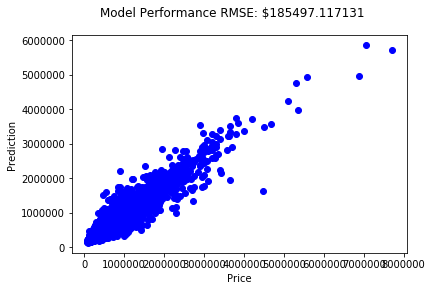

In [115]:
plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('Price')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: $%f " % rmse)
plt.show()

In [50]:
rfPred.show()

+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+-------------+----------+--------------------+------------------+
|    label|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|grade|sqft_above|sqft_basement|yr_built|sqft_living15|sqft_lot15|            features|        prediction|
+---------+--------+---------+-----------+--------+------+----------+----+---------+-----+----------+-------------+--------+-------------+----------+--------------------+------------------+
| 221900.0|       3|      1.0|       1180|    5650|   1.0|         0|   0|        3|    7|      1180|            0|    1955|         1340|      5650|[3.0,1.0,1180.0,5...|331726.92726767156|
| 538000.0|       3|     2.25|       2570|    7242|   2.0|         0|   0|        3|    7|      2170|          400|    1951|         1690|      7639|[3.0,2.25,2570.0,...|  547583.451766169|
| 180000.0|       2|      1.0|        770|   10000